## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns

In [7]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
asos_snotel_UA_df['LXV_WindSpeed_m/s']

asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_Pressure_hp', 'CMtn_WindDirection_deg',
       'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas',
       'CMtn_1hr_Precipitation_mm', 'CMtn_6hr_Precipitation_mm',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=158)


### Create 12 hr snowfall dataframe by using 12hr snowdepth difference

In [9]:
import matplotlib.dates as mdates
#fig = plt.figure(figsize=(10,5))


#Calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'] = asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']  #.resample('12H').first()
asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'] = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']-asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+1)
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in']
asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'] = asos_snotel_UA_df['CMtnSNTL_12hr-dSNWD_in'].shift(-1)


asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']>=3]
asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_gte3_in'] = asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3]

shifted_df = pd.DataFrame()
shifted_df = asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in'].shift(+12).copy()

#fig = plt.figure(figsize=(30,15))
#plt.subplot(2,1, 1)
#plt.subplots_adjust(hspace=0.5, wspace=0.2)




Let's verify that the 12hr snowfall is doing what we think it is

count    306.000000
mean       4.640098
std        2.189155
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       16.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64


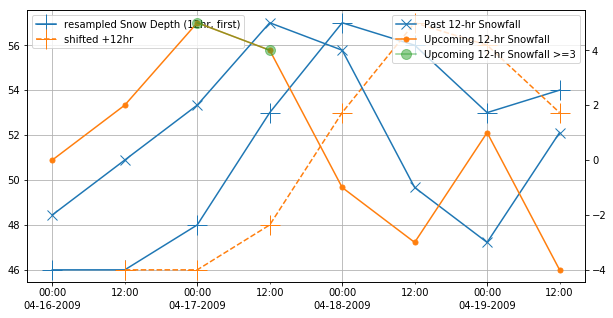

In [10]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
#ax1.plot(asos_snotel_UA_df['CMtnSNTL_SnowDepth_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10, label = "1hr Snow Depth")

ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'], marker='+', markersize = 20, label = "resampled Snow Depth (12hr, first)")
ax1.plot(asos_snotel_UA_df['CMtnSNTL_12hr_SNWD_in']['04-16-2009':'04-19-2009'].shift(+1), marker='+',linestyle='--', markersize = 20, label = "shifted +12hr")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='x', markersize = 10,  label = "Past 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 10,  label = "Upcoming 12-hr Snowfall")
ax2.plot(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']['04-16-2009':'04-19-2009'], marker='.', markersize = 20, alpha = 0.5,  label = "Upcoming 12-hr Snowfall >=3")

#ax2 = asos_snotel_UA_df['CMtn_1hr_Precipitation_mm']['01-06-2009':'01-09-2009'].plot(marker='+', markersize = 10, secondary_y = True)

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # hours and minutes
ax1.xaxis.set_major_formatter(mdates.DateFormatter('\n%m-%d-%Y')) 
#ax00.set_xlim(100, 12)

#plt.plot(shifted_df, linestyle = '-', linewidth = 10)
#print(shifted_df.describe)

#xlabel('Item (s)')
#ylabel('Value')
#title('Python Line Chart: Plotting numbers')

#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')



#print(asos_snotel_df['12hr-dSNWD_in'].describe())
print(asos_snotel_UA_df['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].describe())


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

In [11]:
asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'] = asos_snotel_UA_df['LXV_Pressure_hp']-asos_snotel_UA_df['LXV_Pressure_hp'].shift(+12)
print(asos_snotel_UA_df['LXV_12hr_delta_Pressure_hp'].describe())


count    7915.000000
mean       -0.032788
std        10.266949
min       -43.600000
25%        -6.000000
50%        -0.100000
75%         6.000000
max        41.900000
Name: LXV_12hr_delta_Pressure_hp, dtype: float64


***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2008-2017 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [12]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


In [13]:


OLS_CMtn_Dewpoint = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Dewpoint_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtnSNTL_Temp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtnSNTL_Temp_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_Temperature = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_Temperature_degC',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindSpeed = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindSpeed_mps',asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_CloudCover = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_CloudCover_oktas', asos_snotel_UA_df['2008':'2017']).fit()
OLS_CMtn_WindDirection = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ CMtn_WindDirection_deg', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_12hr_delta_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_12hr_delta_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()
OLS_LXV_Pressure = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~ LXV_Pressure_hp', asos_snotel_UA_df['2008':'2017']).fit()


print(OLS_CMtn_Dewpoint.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtnSNTL_Temp.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_Temperature.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindSpeed.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_CloudCover.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_CMtn_WindDirection.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_12hr_delta_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")
print(OLS_LXV_Pressure.summary())
print("\n ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ \n")



#['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
#       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
#       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
#       'LXV_Temperature_degC', 'LXV_Dewpoint_degC'


#print(a.rsquared)
#print(a.rsquared_adj)
#print(a.rsquared_adj)
#print(a.fvalue)
#print(a.f_pvalue)
#print(a.pvalues)
print(OLS_CMtn_Dewpoint.params)
#qq=sm.qqplot(a.resid, line='r')



                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.012
Model:                                               OLS   Adj. R-squared:                  0.007
Method:                                    Least Squares   F-statistic:                     2.330
Date:                                   Wed, 23 Jan 2019   Prob (F-statistic):              0.129
Time:                                           12:06:04   Log-Likelihood:                -418.58
No. Observations:                                    188   AIC:                             841.2
Df Residuals:                                        186   BIC:                             847.6
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Run OLS model with all variables

In [ ]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

from collections import OrderedDict

variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:

        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    
    print(max_var)
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


In [ ]:
plt.plot(adjRs)

In [ ]:
plt.plot(f_pvalues)

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [49]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    
    
    


Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

**Perform OLS just on "bad" variables"**

In [50]:
from collections import OrderedDict

variables = bad_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    #print(max_var)
    #print(OLS.rsquared)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtn_CloudCover_oktas', 'LXV_CloudCover_oktas', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts']
******


c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\linear_model.py:1549: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\linear_model.py:1550: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\regression\linear_model.py:1558: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid


[0.14631803857581216, 0.29793425974515175, 0.4584442537147393, 0.6328872897413468, 0.7261269919184354, 0.7660909302308823, 0.8320603916813372, 0.8643612458230295, 0.8770537498278252, 0.8895715270975247, 0.9066610342718036, 0.9041198381751372, 0.9290481194097069, 0.964450012777372, 0.9662862199064457, 0.9781527183786278, 0.985198307000828, 0.9826689093193877, 0.9840084505337412, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['KGJT_d850_250_speed_kts', 'LXV_CloudCover_oktas+ KGJT_d850_250_speed_kts', 'KGJT_d850_500_speed_kts+ LXV_CloudCover_oktas+ KGJT_d850_250_speed_kts', 'KGJT_d850_500_drct+ KGJT_d850_500_speed_kts+ LXV_CloudCover_oktas+ KGJT_d850_250_speed_kts', 'KGJT_d850_200_dwpc+ KGJT_d850_500_drct+ KGJT_d850_500_speed_kts+ LXV_CloudCover_oktas+ KGJT_d850_250_speed_kts', 'KGJT_d850_300_dwpc+ KGJT_d850_200_dwpc+ KGJT_d850_500_drct+ KGJT_d850_500_speed_kts+ LXV_CloudCover_oktas+ KGJT_d850_250_speed_kts', 'KGJT_d850_700_tmpc+ KGJT_d850_300_dwpc+ KGJT_d850_200_dwpc+ KGJT_d850_

[0.14631803857581216, 0.29793425974515175, 0.4584442537147393, 0.6328872897413468, 0.7261269919184354, 0.7660909302308823, 0.8320603916813372, 0.8643612458230295, 0.8770537498278252, 0.8895715270975247, 0.9066610342718036, 0.9041198381751372, 0.9290481194097069, 0.964450012777372, 0.9662862199064457, 0.9781527183786278, 0.985198307000828, 0.9826689093193877, 0.9840084505337412, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


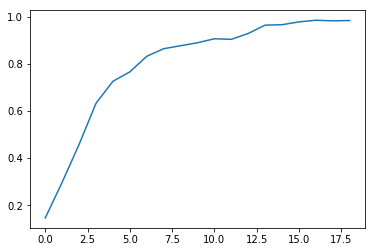

In [51]:
plt.plot(adjRs)
print(adjRs)

[0.0004934045544143967, 0.006560009855115312, 0.0008356009204962178, 3.5679197584607796e-05, 1.7078696843959345e-05, 1.1833321099342553e-05, 2.3436042025813324e-06, 1.3964784179883731e-06, 2.10603181405796e-06, 3.1344180993271666e-06, 3.477305583360392e-06, 1.2275225181072992e-05, 0.0002349812529762584, 9.710979203107226e-05, 0.0003659332035245019, 0.0006734393855680148, 0.002014644081590689, 0.015490285741577924, 0.09683941122064146, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


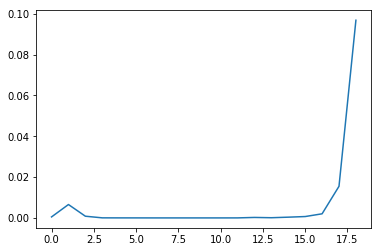

In [52]:
plt.plot(f_pvalues)
print(f_pvalues)

There is some odd behavior here.  Research showed that the high adj R values are due to many missing variable matches to snowfall values, resulting in fictious good fits.  Let's try fitting the model using just the variables with data capture >67%.

### Now run OLS model with the chosen variables ##

In [53]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.13672490423455697
KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed

KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.12328632504579129
KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_

KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
0.11992858790817418
KGJT_d300_200_drc

KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_d

KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d8

KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d70

KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_dr

KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmp

KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ K

KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300

KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dw

KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d

KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+

KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_heigh

KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_hei

KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ K

KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT

CMtn_WindDirection_deg+ CMtn_Temperature_degC+ CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT

**Create plot of adjusted R squared**

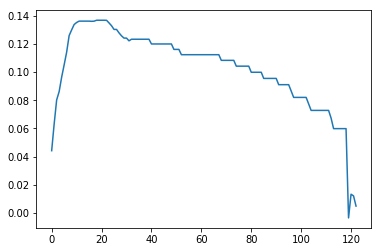

In [54]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

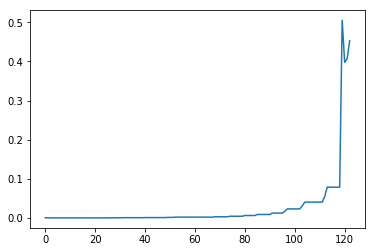

In [55]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [56]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, asos_snotel_UA_df['2008':'2017']).fit()



0 KGJT_500mb_speed_kts 
 Adjusted R: 0.04416179690080091  Fstat(prob): 0.000496261782663362

1 LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.06316261857272665  Fstat(prob): 0.0001208257355541641

2 KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.08020397462215045  Fstat(prob): 3.158123602893503e-05

3 KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.08611884706274808  Fstat(prob): 3.5116437258921644e-05

4 KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.09635078025572086  Fstat(prob): 1.8965790756953514e-05

5 KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.10508756111736262  Fstat(prob): 1.1818762031210642e-05

6 KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb

25 KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.1302490236597713  Fstat(prob): 0.0001222486292058549

26 KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_heig


37 KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 0.12328632504579018  Fstat(prob): 0.0005702852048148589

38 KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d

47 KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 
 Adjusted R: 

55 KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_

63 KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d700_200_speed_kts+ KGJT_200mb_dwpc+ KGJT_d300_250_drct+ KGJT_d700_250_dwpc+ KGJT_700mb_tmpc+ KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT

70 KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ KGJT_d300_250_height_m+ LXV_Pressure_hp+ LXV_Temperature_degC+ KGJT_200mb_drct+ KGJT_d700_200_drct+ LXV_WindDirection_deg+ KGJT_d7

76 KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_d500_200_tmpc+ KGJT_d300_200_height_m+ KGJT_d700_200_tmpc+ KGJT_250mb_height_m+ K


81 KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_250mb_tmpc+ KGJT_200mb_height_m+ KGJT_200mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_250

86 KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_d500_200_drct+ KGJT_d700_500_drct+ KGJT_d700_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+

91 KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d500_400_dwpc+ KGJT_d700_400_dwpc+ KGJT_d400_250_dwpc+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ KGJT_d700_250_drct+ KGJT_

96 CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ KGJT_d400_300_height_m+ KGJT_700mb_height_m+ KGJT_d500_250_height_m+ KGJT_850mb_height_m+ KGJT_d50

100 KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT_d700_300_height_m+ KGJT_d700_250_height_m+ KGJT_d850_200_height_m+ KGJT_500mb_height_m+ 

104 KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d850_300_height_m+ KGJT_d400_250_height_m+ KGJT_d400_200_height_m+ KGJT

108 KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200_height_m+ KGJT_d500_300_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+

112 LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ KGJT_d500_400_drct+ KGJT_d400_250_drct+ KGJT_d500_200_height_m+ KGJT_d700_200

116 KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d400_200_drct+ KGJT_400mb_drct+ KGJT_d700_400_drct+ KGJT_d400_300_drct+ 

120 CMtn_Dewpoint_degC+ CMtn_WindSpeed_mps+ KGJT_d400_300_dwpc+ KGJT_d700_300_dwpc+ KGJT_300mb_dwpc+ KGJT_d500_300_dwpc+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ LXV_12hr_delta_Pressure_hp+ KGJT_500mb_dwpc+ KGJT_400mb_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d700_200_dwpc+ KGJT_700mb_dwpc+ KGJT_d250_200_dwpc+ KGJT_d500_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_250mb_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_250_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d500_400_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d700_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_300_tmpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_400mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_300_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d700_500_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_300_speed_kt

**Find max adj R and obtain OLS summary**

In [46]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts


In [43]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_all.summary())


KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.191
Model:                                               OLS   Adj. R-squared:                  0.137
Method:                                    Least Squares   F-statistic:                     3.535
Date:                                   Wed, 23 Jan 2019   Prob (F-statistic):           1.78e-05
Time:                                           12:50:37   Log-Likelihood:                -519.29
No. Ob

**Print QQ plot**

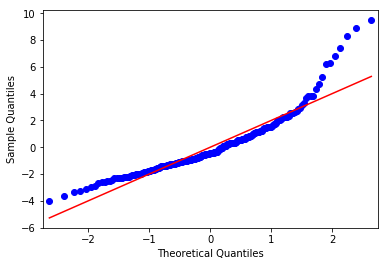

In [57]:
qq2=sm.qqplot(maxOLS_all.resid, line='r')

**There are a few variables with P|t| values which are high, noteably the KGJT_d500_300_speed_kts variable with P|t| of 0.9, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [58]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str, asos_snotel_UA_df['2008':'2017']).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str, asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS_goodp.summary())


KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts
1
KGJT_d500_250_dwpc+ KGJT_d700_400_height_m+ KGJT_300mb_speed_kts+ KGJT_d250_200_tmpc 0.05895945503733768 0.01
0.05895945503733768 0.01
2
KGJT_d500_250_dwpc+ KGJT_d700_400_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.08453075280584743 0.02
0.08453075280584743 0.02
3
KGJT_d500_250_dwpc+ KGJT_d700_400_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d250_200_tmpc+ LXV_Dewpoint_degC 0.08453075280584743 0.03
4
KGJT_d500_250_dwpc+ KGJT_d700_400_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_2

34
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13815757578759225 0.34
35
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13815757578759225 0.35000000000000003
36
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_400_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ LXV_Dewpoint_degC+ KGJT_500

KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13676891784532152 0.56
57
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13676891784532152 0.5700000000000001
58
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_h

KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13676891784532152 0.77
78
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.13676891784532152 0.78
79
KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_

KGJT_d500_250_dwpc+ KGJT_500mb_tmpc+ KGJT_d500_300_drct+ KGJT_d700_500_height_m+ KGJT_d700_400_height_m+ KGJT_d850_500_height_m+ KGJT_d500_300_speed_kts+ KGJT_d850_400_height_m+ KGJT_d850_700_height_m+ KGJT_300mb_height_m+ KGJT_300mb_speed_kts+ KGJT_700mb_drct+ KGJT_d500_250_drct+ KGJT_d500_400_height_m+ KGJT_d250_200_tmpc+ KGJT_d700_500_dwpc+ KGJT_d700_500_tmpc+ LXV_Dewpoint_degC+ KGJT_500mb_speed_kts 0.1367689178453223 0.99

 best threshold is:0.25
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.183
Model:                                               OLS   Adj. R-squared:                  0.140
Method:                                    Least Squares   F-statistic:                     4.246
Date:                                   Wed, 23 Jan 2019   Prob (F-statistic):           4.71e-06
Time:                                           13:16:3

**So it looks like the best P|t| threshold for variable elimination is 0.25.  By doing, this the adjusted R squared only increased slightly to 0.14**

## Try fit parameters with test dataset (2006 and 2007 data)

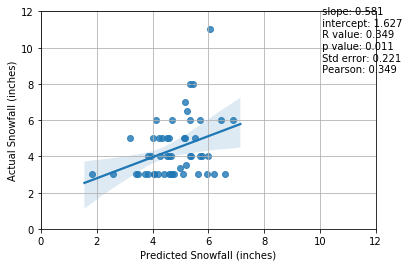

In [114]:

from scipy.stats import pearsonr, linregress
#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3].describe())

actual_snf = asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
#print(actual_snf.describe())


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
sns.regplot(predict[idx], actual_snf[idx])

#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([0,12])
plt.ylim([0,12])
plt.grid(True)
#print(actual_snf.describe())
#print(predict.describe())

Note the lowest possible value in the actual snowfall data is 3 inches.  It looks like the lowest predicted snowfall is only 1 inch.  Let's just add 2 inches of snow across the board to the predicted values and see how this impacts

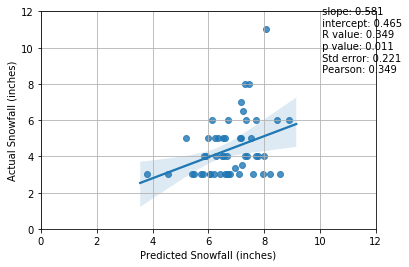

In [115]:

predict = maxOLS_goodp.predict(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['2006':'2007']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])+2
#print(actual_snf.describe())


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
sns.regplot(predict[idx], actual_snf[idx])

#print(asos_snotel_UA_df['2006':'2007'][asos_snotel_UA_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n Std error: ' + str(round(std_err1,3)) +
                 '\n Pearson: ' + str(round(pearson1,3)), \
                 xy=(0.83, 0.72), xycoords='axes fraction', fontsize=10)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([0,12])
plt.ylim([0,12])
plt.grid(True)
#print(actual_snf.describe())
#print(predict.describe())

[4.98424095 4.97480445 4.70961011 4.55886725 5.34369469 3.82799135
 5.25792217 4.35833122 3.87930834 5.18047038 4.60060072 4.30892818
 4.10632268 5.29457035 4.8526515  4.21049205 4.65653833 1.33985957
 6.31786824 4.64228127 5.28159006 4.3717721  3.43249965 4.28231864
 5.17543054 4.29659133 4.39925397 3.40681503 4.58446297 4.83132936
 3.61681323 5.05151966 4.97171454 5.28332768 4.73345433 5.36873586
 4.84464543 4.48901978 4.14755441 2.9391963  6.07234125 4.38191683
 4.41856028 4.25784887 4.6929693  3.76377347 5.16758655]
[ 5.   4.   5.   4.   5.   5.   7.   4.   4.   3.   4.   8.   4.   5.
  8.   3.  11.   3.   6.   3.   3.   4.   3.   5.   6.   4.   4.   3.
  5.   6.   3.   5.   3.   6.5  3.5  3.   3.   3.   3.   3.   6.   4.
  4.   3.   3.   3.   3. ]
[ 0.01575905 -0.97480445  0.29038989 -0.55886725 -0.34369469  1.17200865
  1.74207783 -0.35833122  0.12069166 -2.18047038 -0.60060072  3.69107182
 -0.10632268 -0.29457035  3.1473485  -1.21049205  6.34346167  1.66014043
 -0.31786824 -1.64

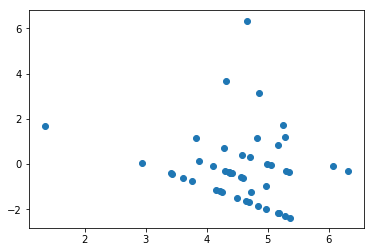

In [30]:
plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
print(actual_snf[idx].values-predict[idx].values)

#print(type(predict))
#print(type(actual_snf))
#sns.regplot(predict[idx], actual_snf[idx]-predict[idx])

**Let's try this without wind direction variables**

In [ ]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc',  'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc',  'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc',  'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc',  'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc',  'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc',  'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc',  'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc',  'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc',  'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc',  'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc',  'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc',  'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc',  'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc',  'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc',  'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc',  'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc',  'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc',  'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc',  'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc',  'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc',  'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc',  'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc',  'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc',  'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc',  'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc',  'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',  'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',  'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df['2008':'2017'][var])
    total_poss = len(asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df['2008':'2017']['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    total_avail =len(asos_snotel_UA_df['2008':'2017'][idx])
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        
print('Variables with >= 75% data match to snowfall: ')
print(good_vars)
print('Variables with < 75% data match to snowfall: ')
print(bad_vars)

In [ ]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, asos_snotel_UA_df['2008':'2017']).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, asos_snotel_UA_df['2008':'2017']).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)


In [ ]:
plt.plot(adjRs)

In [ ]:
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

maxOLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum , asos_snotel_UA_df['2008':'2017']).fit() 
print(maxOLS.summary())
qq2=sm.qqplot(maxOLS.resid, line='r')